
図解！Jupyter Labを徹底解説！(インストール・使い方・拡張 ...# 2
## 2.3.4

In [1]:
import pymc3 as pm
import arviz as az

In [2]:
y_obs = [1, 0, 0,1,1,1,0,1,1,0]

In [3]:
with pm.Model() as model:
    
    theta = pm.Uniform("theta", lower=0, upper=1)#事前分布
    
    y = pm.Bernoulli("y", p=theta, observed = y_obs)#尤度

In [4]:
print(model.basic_RVs)

[theta_interval__ ~ TransformedDistribution, y ~ Bernoulli]


In [5]:
with model:
    trace = pm.sample(
            draws = 6000,
            tune = 2000,
            step = pm.NUTS(),
            chains = 3,
            random_seed = 1,
            return_inferencedata = True)

Multiprocess sampling (3 chains in 4 jobs)
NUTS: [theta]


Sampling 3 chains for 2_000 tune and 6_000 draw iterations (6_000 + 18_000 draws total) took 5 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.581,0.138,0.322,0.829,0.002,0.001,7890.0,11166.0,1.0


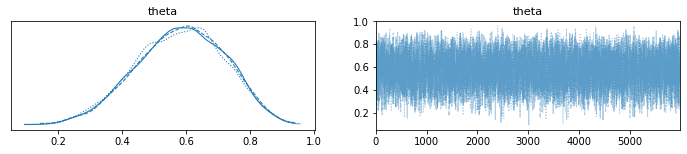

In [6]:
az.plot_trace(trace)
az.summary(trace)

## 2.4
### 2.4.3 

In [23]:
import torch
from torch.distributions import constraints
import pyro
import matplotlib.pyplot as plt
from scipy import stats

In [8]:
y = torch.tensor(y_obs, dtype = torch.float)

In [18]:
def model(y):
    alpha = torch.tensor(1.0)
    beta = torch.tensor(1.0)
    
    theta = pyro.sample('theta', pyro.distributions.Beta(alpha, beta))
    
    with pyro.plate('sample', len(y)): 
        pyro.sample('obs', pyro.distributions.Bernoulli(theta), obs=y)

In [19]:
def guide(y):
    
    alpha_q = pyro.param('alpha_q', torch.tensor(5.0),
                         constraint=constraints.positive)
    beta_q = pyro.param('beta_q', torch.tensor(5.0),
                        constraint = constraints.positive)
    
    pred_p = pyro.sample('theta', pyro.distributions.Beta(alpha_q, beta_q))
    return pred_p

Text(0, 0.5, 'Loss')

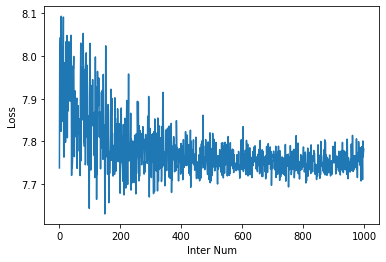

In [20]:
pyro.clear_param_store()
optimizer = pyro.optim.Adam({'lr':0.0005})

svi = pyro.infer.SVI(model, guide, optimizer, loss = pyro.infer.Trace_ELBO(num_particles=30))
loss_list = []
for step in range(1000):
    loss = svi.step(y)
    loss_list.append(loss)
    
plt.plot(loss_list)
plt.xlabel('Inter Num')
plt.ylabel('Loss')

In [21]:
for para_nime in pyro.get_param_store():
    print(para_nime)

alpha_q
beta_q


In [33]:
alpha_q = pyro.param('alpha_q').detach().numpy()
beta_q = pyro.param('beta_q').detach().numpy()
variational_posterior = stats.beta(alpha_q, beta_q)
tmp = variational_posterior.rvs(1000)
print(tmp.mean(), tmp.std())

0.5810145722045686 0.1478351067205721
